In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,8)
import pylab as plt
import numpy as np
import fitsio
from astrometry.util.fits import *
from astrometry.util.util import Tan
from astrometry.util.plotutils import *
from collections import Counter
from astrometry.util.starutil import *
from scipy.ndimage.filters import *
from scipy.ndimage.measurements import label, find_objects
from scipy.ndimage.morphology import binary_dilation, binary_fill_holes

In [41]:
slc = (slice(500, 1200), slice(500, 1200))
gco = fitsio.FITS('25/legacysurvey-custom-036450m04600-image-g.fits.fz')[1][slc]
rco = fitsio.FITS('25/legacysurvey-custom-036450m04600-image-r.fits.fz')[1][slc]
ico = fitsio.FITS('25/legacysurvey-custom-036450m04600-image-i.fits.fz')[1][slc]

In [43]:
ims = [gco,rco,ico]
bands = 'gri'

In [45]:
def sdss_rgb(imgs, bands, scales=None, m=0.03, Q=20):
    rgbscales=dict(g=(2, 6.0),
                   r=(1, 3.4),
                   i=(0, 3.0),
                   z=(0, 2.2))
    if scales is not None:
        rgbscales.update(scales)
    I = 0
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        img = np.maximum(0, img * scale + m)
        I = I + img
    I /= len(bands)
    fI = np.arcsinh(Q * I) / np.sqrt(Q)
    I += (I == 0.) * 1e-6
    H,W = I.shape
    rgb = np.zeros((H,W,3), np.float32)
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        rgb[:,:,plane] = np.clip((img * scale + m) * fI / I, 0, 1)
    return rgb

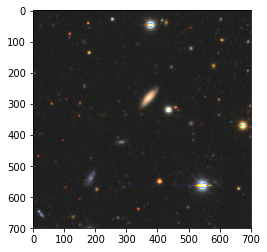

In [47]:
rgb = sdss_rgb(ims, bands)
plt.imshow(rgb);

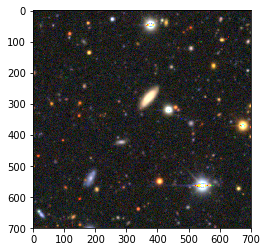

In [54]:
s = 4
scale = dict(g=(2, 6.0*s),
            r=(1, 3.4*s),
            i=(0, 3.0*s))
plt.imshow(sdss_rgb(ims, bands, scales=scale));

In [2]:
g_det = fitsio.read('25/detmap-g.fits')
g_detiv = fitsio.read('25/detiv-g.fits')
r_det = fitsio.read('25/detmap-r.fits')
r_detiv = fitsio.read('25/detiv-r.fits')
i_det = fitsio.read('25/detmap-i.fits')
i_detiv = fitsio.read('25/detiv-i.fits')

img = plt.imread('25/legacysurvey-custom-036450m04600-image.jpg')
img = np.flipud(img)
H,W,three = img.shape

ra,dec = 36.45, -4.6
pixscale = 0.262 / 3600.
wcs = Tan(ra, dec, W/2.+0.5, H/2.+0.5,
        -pixscale, 0., 0., pixscale,
        float(W), float(H))

In [4]:
Ng = fitsio.read('25/legacysurvey-custom-036450m04600-nexp-g.fits.fz')
Nr = fitsio.read('25/legacysurvey-custom-036450m04600-nexp-r.fits.fz')
Ni = fitsio.read('25/legacysurvey-custom-036450m04600-nexp-i.fits.fz')
good = ((Ng > 12) * (Nr > 12) * (Ni > 12))

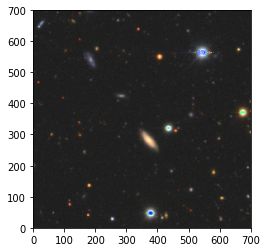

In [5]:
#plt.imshow(img, origin='lower');
#plt.imshow(good, origin='lower', cmap='gray');
plt.imshow(img[500:1200, 500:1200], origin='lower');

In [6]:
def sedsn(detmaps, detivs, sed):
    H,W = detmaps[0].shape
    sedmap = np.zeros((H,W), np.float32)
    sediv  = np.zeros((H,W), np.float32)
    for detmap,detiv,s in zip(detmaps,detivs,sed):
        if s == 0:
            continue
        # We convert the detmap to canonical band via
        #   F_i = detmap_i / sed_i
        # And the corresponding change to sig1 is
        #   sig_f = sig1_i / sed_i
        # And invvar is
        #   invvar_f,i = sed_i^2 / sig1_i^2
        #   invvar_f,i = sed_i^2 * detiv_i
        # So the invvar-weighted accumulator is
        #   F_i * invvar_f,i = (detmap_i / sed_i) * (sed_i^2 * detiv_i)
        #                    = detmap_i * detiv_i * sed_i
        sedmap += detmap * detiv * s
        sediv  += detiv  * s**2
    sedmap /= np.maximum(1e-16, sediv)
    sedsn   = sedmap * np.sqrt(sediv)
    return sedsn

In [7]:
detmaps = [g_det, r_det, i_det]
detivs = [g_detiv, r_detiv, i_detiv]

def colorsed(gr, ri):
    return np.array([10.**(-0.4*gr), 1., 10.**(-0.4*-ri)])

class SED(object):
    def __init__(self, name, plotcolor, sed):
        self.name = name
        self.plotcolor = plotcolor
        self.sed = sed
        self.tname = name.replace('-','_') + '_sn'
    def __repr__(self):
        return self.name + ': ' + str(self.sed)

sedlist = [
    SED('blue', '0.5', colorsed(0., 0.)),
    SED('yellow', 'orange', colorsed(1., 0.3)),
    SED('red', 'r', colorsed(1.5, 1.)),
    #SED('blue', 'b', colorsed(-0.5, -0.5)),
    #SED('mid', colorsed(0.8, 0.6)),
    SED('g-only', 'g', np.array([1., 0., 0.])),
    SED('r-only', 'pink', np.array([0., 1., 0.])),
    SED('i-only', 'i', np.array([0., 0., 1.])),
]
for s in sedlist:
    print('%8s' % s.name, '   '.join(['%6.3f' % x for x in s.sed]))

for s in sedlist:
    s.snmap = sedsn(detmaps, detivs, s.sed)
#sedlist = [(n, s, sedsn(detmaps, detivs, s)) for n,s in sedlist]

#flat_sn = sedlist[0][-1]
flat_sn = sedlist[0].snmap
yellow_sn = sedlist[1].snmap

#flat_sn = sedsn(detmaps, detivs, [1., 1., 1.])
#red_sn  = sedsn(detmaps, detivs, [2.5, 1., 0.4])
#blue_sn = sedsn(detmaps, detivs, [0.4, 1., 2.5])
#yel_sn = sedsn(detmaps, detivs, [2.5, 1, 10.**(-0.4 * 0.3)])
#redder_sn  = sedsn(detmaps, detivs, [10.**(-0.4 * -1.5), 1., 10.**(-0.4 * 1.)])
#mid_sn = sedsn(detmaps, detivs, [10.**(-0.4 * -0.75), 1., 10.**(-0.4 * 0.6)])

    blue  1.000    1.000    1.000
  yellow  0.398    1.000    1.318
     red  0.251    1.000    2.512
  g-only  1.000    0.000    0.000
  r-only  0.000    1.000    0.000
  i-only  0.000    0.000    1.000


In [8]:
def detect_sources(snmap, threshold):
    hot = (snmap > threshold)
    hot = binary_dilation(hot, iterations=2)
    hot = binary_fill_holes(hot)
    blobs,nblobs = label(hot)
    print(nblobs, 'blobs')
    print('blobs min', blobs.min(), 'max', blobs.max())
    slices = find_objects(blobs)
    px,py = [],[]
    for i,slc in enumerate(slices):
        blob_loc = blobs[slc]
        sn_loc = snmap[slc]
        imax = np.argmax((blob_loc == (i+1)) * sn_loc)
        y,x = np.unravel_index(imax, blob_loc.shape)
        y0,x0 = slc[0].start, slc[1].start
        px.append(x0+x)
        py.append(y0+y)
        #if i == 0:
        #    plt.subplot(2,2,1)
        #    plt.imshow(blob_loc, interpolation='nearest', origin='lower')
        #    plt.colorbar()
        #    plt.subplot(2,2,2)
        #    plt.imshow((blob_loc==(i+1))*sn_loc, interpolation='nearest', origin='lower')
        #    plt.subplot(2,2,3)
        #    plt.plot(x, y, 'ro')
    return np.array(px),np.array(py)

In [36]:
x,y = detect_sources(yellow_sn, 100.)
sources = fits_table()
sources.x = x
sources.y = y
sources.cut(good[sources.y, sources.x])
print('Cut to', len(sources), 'good sources')
sz = 20
H,W = good.shape
sources.cut((sources.x > sz) * (sources.y > sz) * (sources.x < (W-sz)) * (sources.y < (H-sz)))
print(len(sources), 'not near edges')
sources.cut((g_detiv[sources.y, sources.x] > 0) * (r_detiv[sources.y, sources.x] > 0) * (i_detiv[sources.y, sources.x] > 0))
print(len(sources), 'with gri obs')

for s in sedlist:
    sources.set(s.tname, s.snmap[sources.y, sources.x])

sources.g_sn = (g_det[sources.y, sources.x] * np.sqrt(g_detiv[sources.y, sources.x]))
sources.r_sn = (r_det[sources.y, sources.x] * np.sqrt(r_detiv[sources.y, sources.x]))
sources.i_sn = (i_det[sources.y, sources.x] * np.sqrt(i_detiv[sources.y, sources.x]))
sources.g_flux = g_det[sources.y, sources.x]
sources.r_flux = r_det[sources.y, sources.x]
sources.i_flux = i_det[sources.y, sources.x]
sources.ra,sources.dec = wcs.pixelxy2radec(sources.x+1, sources.y+1)
sources.g_mag = -2.5*(np.log10(sources.g_flux) - 9)
sources.r_mag = -2.5*(np.log10(sources.r_flux) - 9)
sources.i_mag = -2.5*(np.log10(sources.i_flux) - 9)

I = np.argsort(-sources.yellow_sn)
sources.cut(I)

2220 blobs
blobs min 0 max 2220
Cut to 2111 good sources
2085 not near edges
2085 with gri obs


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


median g-r: 0.7804203 r-i: 0.3940506


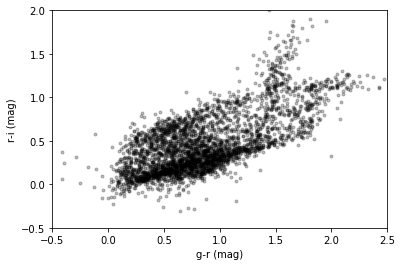

In [29]:
plt.plot(sources.g_mag - sources.r_mag, sources.r_mag - sources.i_mag, 'k.', alpha=0.25)
plt.axis([-0.5, 2.5, -.5, 2])
plt.xlabel('g-r (mag)')
plt.ylabel('r-i (mag)');
I = np.flatnonzero(np.isfinite(sources.g_mag) * np.isfinite(sources.r_mag) * np.isfinite(sources.i_mag))
print('median g-r:', np.median(sources.g_mag[I] - sources.r_mag[I]), 'r-i:', np.median(sources.r_mag[I] - sources.i_mag[I]))

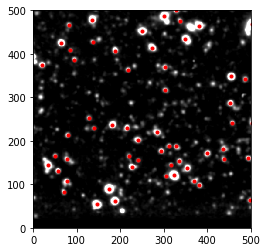

In [30]:
plt.imshow(yellow_sn, interpolation='nearest', origin='lower', vmin=0, vmax=50, cmap='gray')
ax = plt.axis()
plt.plot(sources.x, sources.y, 'r.')
plt.axis(ax)
plt.axis([0,500,0,500]);

In [ ]:
plt.subplots_adjust(hspace=0.01, wspace=0.01)
N=100
R,C = 9,12
for i in range(len(sources)):
    if i >= R*C:
        break
    plt.subplot(R,C,i+1)
    f = sources[i]
    plt.imshow(img[f.y-sz : f.y+sz+1, f.x-sz : f.x+sz+1, :], interpolation='nearest', origin='lower')
    plt.xticks([]); plt.yticks([])    

In [31]:
def show_sources(T, img):
    sz = 10
    imgrows = []
    R,C = 10,10
    k = 0
    for i in range(R):
        imgrow = []
        for j in range(C):
            if k >= len(T):
                sub = np.zeros((sz*2+1,sz*2+1,3), np.uint8)
            else:
                f = T[k]
                sub = img[f.y-sz : f.y+sz+1, f.x-sz : f.x+sz+1, :]
            imgrow.append(sub)
            k += 1
        imgrow = np.hstack(imgrow)
        #print('imgrow', imgrow.shape)
        imgrows.append(imgrow)
    imgrows = np.vstack(reversed(imgrows))
    plt.imshow(imgrows, interpolation='nearest', origin='lower')
    plt.xticks([]); plt.yticks([]);

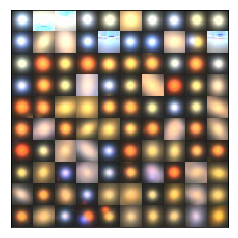

In [32]:
show_sources(sources, img)

In [ ]:
I = np.argsort(-sources.red_sn / sources.flat_sn)
show_sources(sources[I], img)

In [ ]:
I = np.argsort(-sources.blue_sn / sources.flat_sn)
show_sources(sources[I], img)

In [37]:
sources.imax = np.argmax(np.vstack([sources.get(s.tname) for s in sedlist]), axis=0)

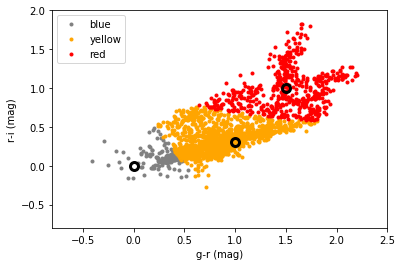

In [38]:
for i,s in enumerate(sedlist):
    sed = s.sed
    if not np.all(sed > 0):
        continue
    I = np.flatnonzero(sources.imax == i)
    plt.plot(sources.g_mag[I] - sources.r_mag[I], sources.r_mag[I] - sources.i_mag[I], '.', label=s.name,
            color=s.plotcolor)
    gr = -2.5 * np.log10(sed[0] / sed[1])
    ri = -2.5 * np.log10(sed[1] / sed[2])
    #print(sedlist[i].name, 'gr', gr, 'ri', ri)
    plt.plot(gr, ri, 'ko', mfc='none', ms=8, mew=3)
plt.axis([-0.8, 2.5, -0.8, 2])
plt.xlabel('g-r (mag)')
plt.ylabel('r-i (mag)')
plt.legend();
plt.savefig('best-color.png')

Coords: [(922, 1547), (920, 1580), (3262, 650), (3630, 1076), (2349, 867), (1455, 450), (1240, 185), (3917, 196), (1905, 2507), (3495, 3691)]


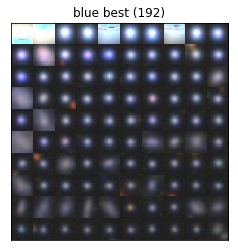

Coords: [(1096, 1766), (3097, 3244), (1723, 1826), (1109, 1057), (3853, 3707), (3696, 3094), (617, 2442), (2645, 3635), (764, 1425), (1442, 3367)]


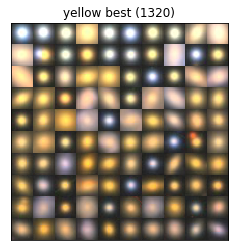

Coords: [(242, 2784), (1858, 2635), (2916, 3696), (933, 553), (3407, 514), (1664, 2508), (3877, 3368), (1430, 4238), (3797, 1353), (1229, 3504)]


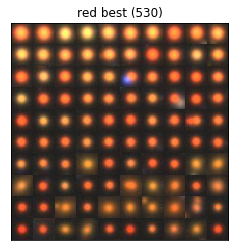

Coords: [(479, 3168), (3038, 475), (1908, 434), (2232, 3039), (1952, 3028), (542, 2968), (399, 1540)]


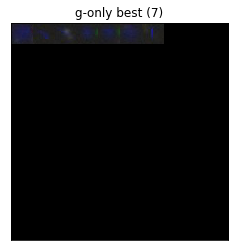

Coords: [(2603, 3450), (522, 2967), (2247, 3038), (1539, 2454), (2039, 3337), (1965, 3026), (1402, 682), (1597, 1847), (1035, 4159), (625, 1396)]


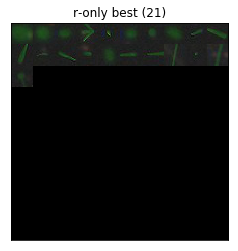

Coords: [(150, 3123), (74, 3259), (3157, 4331), (2864, 2516), (3501, 611), (3448, 1384), (701, 3102), (3645, 890), (2367, 1686), (1538, 3764)]


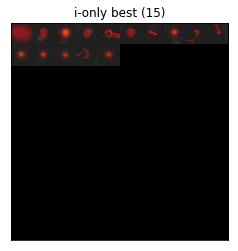

In [39]:
for i,s in enumerate(sedlist):
    I = np.flatnonzero(sources.imax == i)
    #print(len(I), s.name)
    show_sources(sources[I], img)
    plt.title('%s best (%i)' % (s.name, len(I)));
    plt.savefig('best-%s.png' % s.name)
    print('Coords:', list(zip(sources.x[I], 4400-sources.y[I]))[:10])
    plt.show();

In [ ]:
plt.plot(sources.red_sn / sources.flat_sn, 'r.');

In [23]:
DES = fits_table('des-db.fits')
print(len(DES))
DES.cut((DES.mag_auto_g < 99) * (DES.mag_auto_r < 99) * (DES.mag_auto_i < 99))
print(len(DES))
ok,x,y = wcs.radec2pixelxy(DES.ra, DES.dec)
DES.x = (x-1).astype(np.int)
DES.y = (y-1).astype(np.int)
DES.cut((DES.x > sz) * (DES.y > sz) * (DES.x < (W-sz)) * (DES.y < (H-sz)))
print(len(DES))
DES.cut((g_detiv[DES.y, DES.x] > 0) * (r_detiv[DES.y, DES.x] > 0) * (i_detiv[DES.y, DES.x] > 0))
print(len(DES))

22354
21686
5906
5724


In [ ]:
plt.hist(DES.mag_auto_g);

In [24]:
MI,MJ,d = match_radec(sources.ra, sources.dec, DES.ra, DES.dec, 1./3600, nearest=True)
len(MI), len(sources)
MDES = DES[MJ]
Msources = sources[MI]

In [ ]:
#plt.plot(DES.mag_auto_g - DES.mag_auto_r, DES.mag_auto_r - DES.mag_auto_i, 'r.')
plt.plot(MDES.mag_auto_g - MDES.mag_auto_r, MDES.mag_auto_r - MDES.mag_auto_i, 'k.')
plt.axis([-0.5, 3, -0.5, 2]);

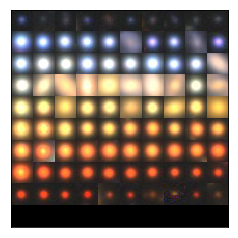

In [25]:
## FIXME -- star vs galaxy; isolated
colorbins = np.linspace(-0.5, 4.0, 10)
#colorbins = np.linspace(-0.5, 4.0, 19)
II = []
K = []
DES.gi = DES.mag_auto_g - DES.mag_auto_i
for clo,chi in zip(colorbins, colorbins[1:]):
    C = np.flatnonzero((DES.gi >= clo) * (DES.gi < chi))
    minmag = np.vstack((DES.mag_auto_g, DES.mag_auto_r, DES.mag_auto_i)).max(axis=0)[C]
    #I.extend(J[np.argsort(DES.mag_auto_r[J])[:10]])
    C = C[np.argsort(np.abs(minmag - 17.9))]
    II.extend(C[:10])
    K.append(C[0])
    #print('min mags', np.sort(minmag)[:10])
    #print('r mags', np.sort(DES.mag_auto_r[J])[:10])
show_sources(DES[II], img)

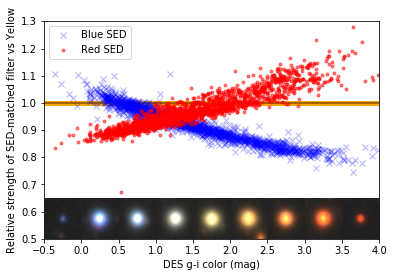

In [27]:
plt.axhline(1., color='orange', lw=5)
plt.axhline(1., color='k', alpha=0.5)
plt.plot(MDES.mag_auto_g - MDES.mag_auto_i, Msources.blue_sn / Msources.yellow_sn, 'bx', alpha=0.3,
        label='Blue SED');
plt.plot(MDES.mag_auto_g - MDES.mag_auto_i, Msources.red_sn  / Msources.yellow_sn, 'r.', alpha=0.5,
        label='Red SED');
plt.xlabel('DES g-i color (mag)')
plt.ylabel('Relative strength of SED-matched filter vs Yellow');
plt.legend(loc='upper left')
ymin = 0.5
plt.axis([-0.5, 4.0, ymin, 1.3])
ax = plt.axis()
aspect = plt.gca().get_aspect()
for clo,chi,k in zip(colorbins, colorbins[1:], K):
    x,y = DES.x[k], DES.y[k]
    plt.imshow(img[y-sz:y+sz+1, x-sz:x+sz+1], interpolation='nearest', origin='lower',
              extent=[clo,chi,ymin,ymin+0.15], zorder=20)
plt.axis(ax)
plt.gca().set_aspect(aspect);
plt.savefig('strength3.png')

In [ ]:
# Galaxy detection.
from tractor.splinesky import SplineSky
from tractor.psfex import PixelizedPsfEx
from astrometry.util.util import wcs_pv2sip_hdr

imfn = '1/data/images/decam/cp/c4d_160814_085515_ooi_g_v1-N4.fits'
im = fitsio.read(imfn)                 
dq = fitsio.read('1/data/images/decam/cp/c4d_160814_085515_ood_g_v1-N4.fits')
wt = fitsio.read('1/data/images/decam/cp/c4d_160814_085515_oow_g_v1-N4.fits')
sig1 = 1./np.sqrt(np.median(wt[dq==0]))
H,W = im.shape

hdr = fitsio.read_header(imfn, ext=1)
imwcs = wcs_pv2sip_hdr(hdr)

fn = '1/data/calib/decam/splinesky/00563/00563982/decam-00563982-N4.fits'
sky = SplineSky.from_fits(fn, None)
sky.addTo(im, scale=-1)
psf = PixelizedPsfEx('1/data/calib/decam/psfex/00563/00563982/decam-00563982-N4.fits')

In [ ]:
#plt.hist(im.ravel(), range=(-5.*sig1, 5.*sig1), bins=100);

In [ ]:
from tractor import Image, NullWCS, ExpGalaxy, ConstantSky, LinearPhotoCal, NanoMaggies, PixPos, GaussianMixturePSF, Tractor
from tractor.ellipses import EllipseE

In [ ]:
v = (psf.fwhm / 2.35)**2
gpsf = GaussianMixturePSF(1., 0., 0., v, v, 0)                          
tim = Image(data=im, inverr=(dq == 0)*1./sig1, wcs=NullWCS(pixscale=0.262),
           psf=psf, sky=ConstantSky(0.), photocal=LinearPhotoCal(1., band='g'))

In [ ]:
gal = ExpGalaxy(PixPos(W/2., H/2.), NanoMaggies(g=1.), EllipseE(0.5, 0., 0.))
mog = gal._getAffineProfile(tim, W/2., H/2.)
#print(mog)
mog.var[:,0,0]

In [ ]:
#tr = Tractor([tim], [gal])
mod = gal.getModelPatch(tim)
tim.psf = gpsf
gmod = gal.getModelPatch(tim)
print(mod.patch.min(), mod.patch.max())
print(gmod.patch.min(), gmod.patch.max())
plt.subplot(1,2,1)
plt.imshow(mod.patch, interpolation='nearest', origin='lower')
plt.subplot(1,2,2)
plt.imshow(gmod.patch, interpolation='nearest', origin='lower')

In [ ]:
psf_sigma = psf.fwhm / 2.35
print('PSF sigma:', psf_sigma)

gpsf = gmod.patch
print('gal x psf sum', gpsf.sum())
gpsf /= gpsf.sum()
gpsfnorm = np.sqrt(np.sum(gpsf**2))
print('gal x psf norm', gpsfnorm)

gdetsum = 0.
for amp,sigma in zip(mog.amp, np.sqrt(mog.var[:,0,0])):
    sig = np.hypot(psf_sigma, sigma)
    gdetsum = gdetsum + amp * gaussian_filter(im, sig)
    print(gdetsum.shape)
gdetsum /= gpsfnorm**2
gdetsig = sig1 / gpsfnorm

# PSF detection map
psfnorm = 1./(2.*np.sqrt(np.pi)*psf_sigma)
print('PSF norm', psfnorm)
psfdet = gaussian_filter(im, psf_sigma) / psfnorm**2
psfsig1 = sig1 / psfnorm

In [ ]:
psfsn = psfdet / psfsig1
galsn = gdetsum / gdetsig

plt.subplot(1,2,1)
plt.imshow(psfsn, interpolation='nearest', origin='lower', vmin=-3, vmax=10.)
plt.subplot(1,2,2)
plt.imshow(galsn, interpolation='nearest', origin='lower', vmin=-3, vmax=10.);

In [ ]:
psf = fits_table()
# x,y in detection image
psf.dx,psf.dy = detect_sources(psfsn, 10.)
gal = fits_table()
gal.dx, gal.dy = detect_sources(galsn, 10.)

psf.psf_sn = psfsn[psf.dy, psf.dx]
psf.gal_sn = galsn[psf.dy, psf.dx]
gal.psf_sn = psfsn[gal.dy, gal.dx]
gal.gal_sn = galsn[gal.dy, gal.dx]
print(len(psf), 'PSF detections')
print(len(gal), 'Galaxy detections')

In [ ]:
# for viewing, convert to x,y in RGB image.
r,d = imwcs.pixelxy2radec(psf.dx+1, psf.dy+1)
ok,x,y = wcs.radec2pixelxy(r, d)
psf.x = (x-1).astype(int)
psf.y = (y-1).astype(int)

r,d = imwcs.pixelxy2radec(gal.dx+1, gal.dy+1)
ok,x,y = wcs.radec2pixelxy(r, d)
gal.x = (x-1).astype(int)
gal.y = (y-1).astype(int)

H,W,nil = img.shape
galok = gal[(gal.x > sz) * (gal.y > sz) * (gal.x < (W-sz)) * (gal.y < (H-sz))]
#galok.cut((g_detiv[galok.y, galok.x] > 0) * (r_detiv[galok.y, galok.x] > 0) * (i_detiv[galok.y, galok.x] > 0))

#I = np.argsort(-galok.gal_sn / galok.psf_sn);
I = np.argsort(-(galok.gal_sn - galok.psf_sn))
show_sources(galok[I], img)

In [ ]:
S = fits_table('sweep-240p005-250p010.fits')
len(S)

In [ ]:
S.mag_g = -2.5*(np.log10(S.flux_g)-9)
S.mag_r = -2.5*(np.log10(S.flux_r)-9)
S.mag_z = -2.5*(np.log10(S.flux_z)-9)

In [ ]:
plothist(S.mag_g - S.mag_r, S.mag_r - S.mag_z, range=((-1,5),(-1,5)));
#plt.axis([-1, 5, -1, 5])
